In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import cv2

In [2]:
shift0 = plt.imread('D:\Projects\pythonProject\CV\course_resources\ps_5\TestSeq\Shift0.png')
shiftR2 = plt.imread('D:\Projects\pythonProject\CV\course_resources\ps_5\TestSeq\ShiftR2.png')
shiftR5U5 = plt.imread('D:\Projects\pythonProject\CV\course_resources\ps_5\TestSeq\ShiftR5U5.png')

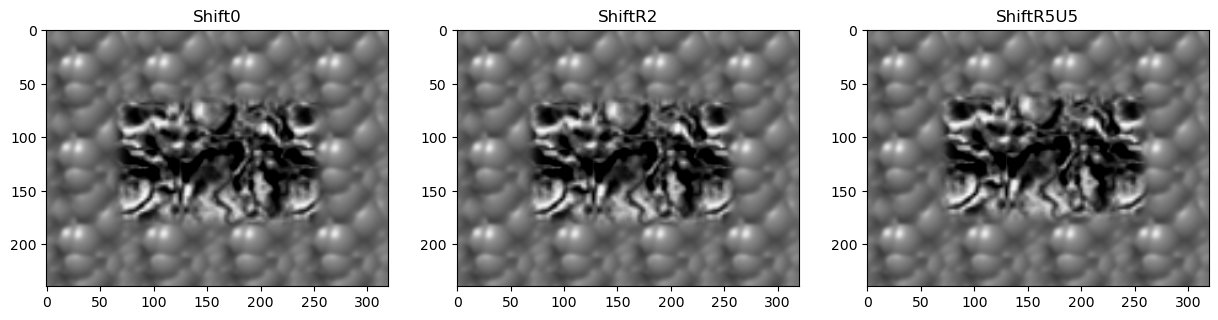

In [3]:
# show images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(shift0)
plt.title('Shift0')
plt.subplot(1, 3, 2)
plt.imshow(shiftR2)
plt.title('ShiftR2')
plt.subplot(1, 3, 3)
plt.imshow(shiftR5U5)
plt.title('ShiftR5U5')
plt.show()

In [4]:
is_grayscale = np.all(shift0[:, :, 0] == shift0[:, :, 1]) and np.all(shift0[:, :, 1] == shift0[:, :, 2])
print(is_grayscale)

True


In [5]:
# Convert RGBA image to grayscale
shift0_gray = shift0[:, :, 0]  # Pick one of R, G, or B, since they are all the same
shiftR2_gray = shiftR2[:, :, 0]
shiftR5U5_gray = shiftR5U5[:, :, 0]

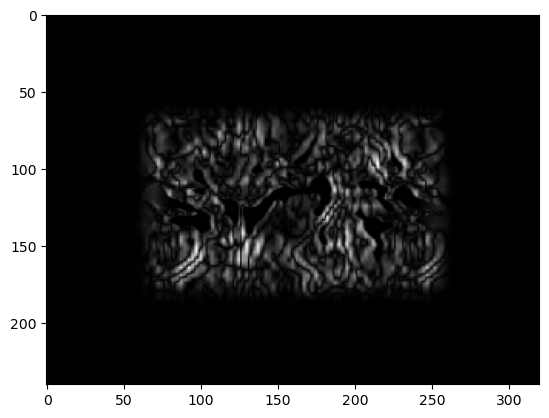

In [6]:
plt.imshow(np.abs(shift0_gray - shiftR2_gray), cmap='gray')
plt.show()

In [7]:
def x_gradient(img):
    return cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)


def y_gradient(img):
    return cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)


def temporal_diff(img1, img2):
    return img2 - img1


def temporal_diff_in_window(img1, img2, k_size=2):
    return convolve(img2, np.ones((k_size, k_size))) - convolve(img1, np.ones((k_size, k_size)))

In [46]:
def KL_step(img1, img2, window_size=5):
    # A = (Ix(p1) , Iy(p1))
    #     (Ix(p2) , Iy(p2))
    #     ...
    #     (Ix(pw) , Iy(pw))
    #
    # b = (It(p1))
    #     (It(p2))
    #     ...
    #     (It(pw))
    # 
    # x = (u, v)
    #
    # A * x = b
    # A^T * A * (u, x) = A^T * b
    #
    # A^T * A = (sum(Ix^2), sum(IxIy))
    #           (sum(IxIy), sum(Iy^2))
    #
    # A^T * b = (sum(IxIt), sum(IyIt))

    img1 = img1 / 255.0
    img2 = img2 / 255.0

    Ix = x_gradient(img1)
    Iy = y_gradient(img1)
    # It = temporal_diff(img1, img2)
    It = temporal_diff_in_window(img1, img2)

    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    IxIy = Ix * Iy
    IxIt = Ix * It
    IyIt = Iy * It

    # kernel = cv2.getGaussianKernel(window_size, -1)  # Use a Gaussian filter for better weighting
    # Ix2_summed_in_window = convolve(Ix2, kernel)
    # Iy2_summed_in_window = convolve(Iy2, kernel)
    # IxIy_summed_in_window = convolve(IxIy, kernel)
    # IxIt_summed_in_window = convolve(IxIt, kernel)
    # IyIt_summed_in_window = convolve(IyIt, kernel)

    Ix2_summed_in_window = convolve(Ix2, np.ones((window_size, window_size)))
    Iy2_summed_in_window = convolve(Iy2, np.ones((window_size, window_size)))
    IxIy_summed_in_window = convolve(IxIy, np.ones((window_size, window_size)))
    IxIt_summed_in_window = convolve(IxIt, np.ones((window_size, window_size)))
    IyIt_summed_in_window = convolve(IyIt, np.ones((window_size, window_size)))

    # Stack along the last axis to create (240, 320, 2, 2)
    A = np.stack([np.stack([Ix2_summed_in_window, IxIy_summed_in_window], axis=-1),
                  np.stack([IxIy_summed_in_window, Iy2_summed_in_window], axis=-1)], axis=-2)

    epsilon = 1e-8  # Small regularization term
    A += (np.eye(2) * epsilon)

    # Stack along the last axis to create (240, 320, 2)
    b = np.stack([IxIt_summed_in_window, IyIt_summed_in_window], axis=-1)

    # A_inv = np.linalg.inv(A)
    # uv = np.einsum('...ij,...j->...i', A_inv, b)
    uv = np.linalg.solve(A, b)

    return uv

In [9]:
def view_displacement(uv):
    plt.figure(figsize=(15, 5))

    # Normalize the color scale
    # uv = (uv - np.min(uv)) / (np.max(uv) - np.min(uv))

    # Get the min and max values across both u and v to normalize the color scale
    vmin = np.min(uv)
    vmax = np.max(uv)

    # Plot 'u' displacement
    plt.subplot(1, 2, 1)
    u_plot = plt.imshow(uv[..., 0], vmin=vmin, vmax=vmax)
    plt.title('u')
    plt.colorbar(u_plot)

    # Plot 'v' displacement
    plt.subplot(1, 2, 2)
    v_plot = plt.imshow(uv[..., 1], vmin=vmin, vmax=vmax)
    plt.title('v')
    plt.colorbar(v_plot)

    plt.show()

In [10]:
def view_arrows(uv, scale=3, **kwargs):
    plt.quiver(uv[::scale, ::scale, 0], uv[::scale, ::scale, 1], **kwargs)
    plt.show()

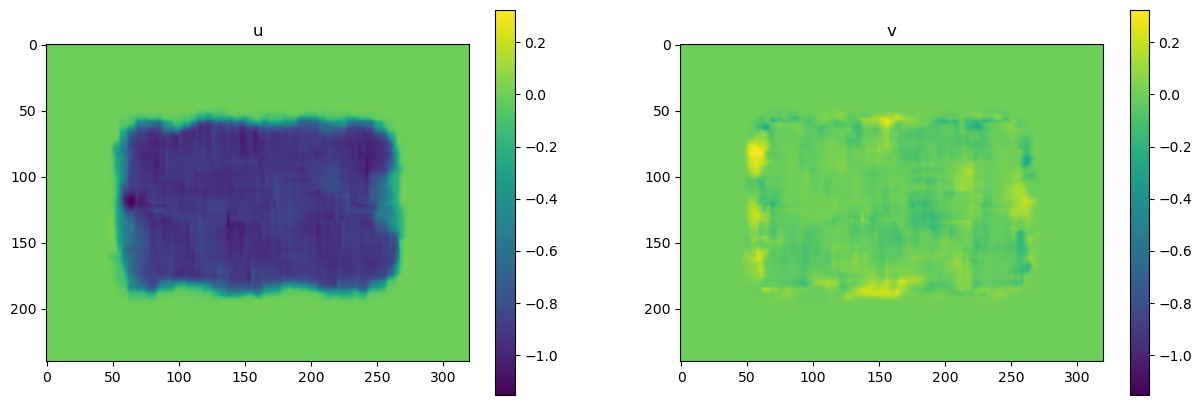

In [11]:
# window size 5 is to small to find meaningful gradients
uv = KL_step(shift0_gray, shiftR2_gray, window_size=21)
view_displacement(uv)

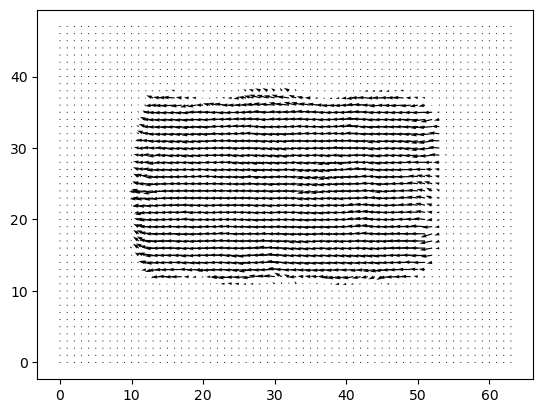

In [12]:
view_arrows(uv, scale=5)

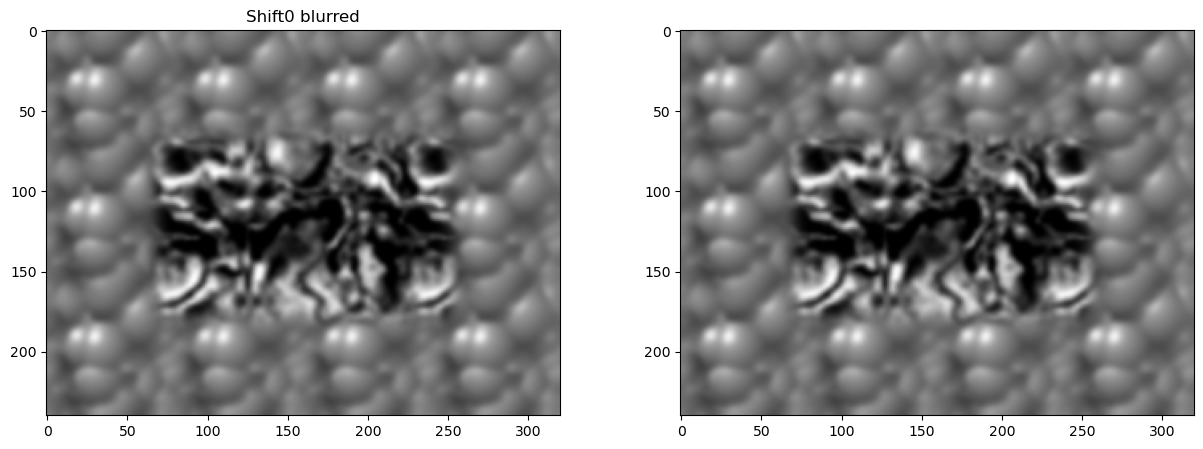

In [13]:
# lets try to blurr the images first with a gaussian filter
from scipy.ndimage import gaussian_filter


def blur_image(img, sigma=1):
    return gaussian_filter(img, sigma=sigma)


shift0_blurred = blur_image(shift0_gray, sigma=1)
shiftR2_blurred = blur_image(shiftR2_gray, sigma=1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(shift0_blurred, cmap='gray')
plt.title('Shift0 blurred')
plt.subplot(1, 2, 2)
plt.imshow(shiftR2_blurred, cmap='gray')

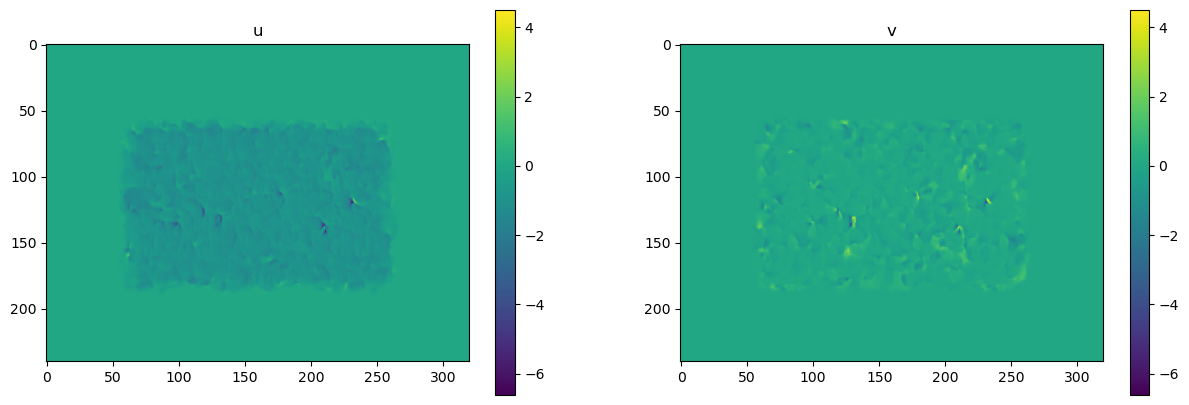

In [14]:
uv_blurred = KL_step(shift0_blurred, shiftR2_blurred, window_size=5)
view_displacement(uv_blurred)

In [15]:
# improvement but still not perfect.
# Let try to implement iterative Lucas-Kanade

def warp_image(img, uv):
    """Warp img according to flow uv using bilinear interpolation."""
    h, w = img.shape[:2]

    # Create a grid of coordinates
    x, y = np.meshgrid(np.arange(w), np.arange(h))

    # Apply displacement (u, v)
    x_new = (x + uv[..., 0]).astype(np.float32)
    y_new = (y + uv[..., 1]).astype(np.float32)

    # Use OpenCV remap for bilinear interpolation to warp the image
    img_warped = cv2.remap(img, x_new, y_new, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                           borderValue=0)

    return img_warped


def iterative_KL(img1, img2, window_size=5, num_iters=10):
    uv = np.zeros((img1.shape[0], img1.shape[1], 2))  # Initialize flow to zero

    for i in range(num_iters):
        # Warp img1 based on the current flow field
        img1_wrapped = warp_image(img1, uv)

        # Calculate the flow increment using KL_step
        delta_uv = KL_step(img1_wrapped, img2, window_size)

        # Update the flow field
        uv += delta_uv

        print(f"iter {i} delta_uv min:", np.min(np.abs(delta_uv)), "max:", np.max(np.abs(delta_uv)))

    return uv

iter 0 delta_uv min: 0.0 max: 6.620998202293058
iter 1 delta_uv min: 0.0 max: 2.08881293115878
iter 2 delta_uv min: 0.0 max: 2.801748662966738
iter 3 delta_uv min: 0.0 max: 1.5745986844465203
iter 4 delta_uv min: 0.0 max: 0.9907037728805824
iter 5 delta_uv min: 0.0 max: 1.1285141870620439
iter 6 delta_uv min: 0.0 max: 1.3863237972946723
iter 7 delta_uv min: 0.0 max: 1.478212026863264
iter 8 delta_uv min: 0.0 max: 1.293245001984517
iter 9 delta_uv min: 0.0 max: 1.3132395218409472


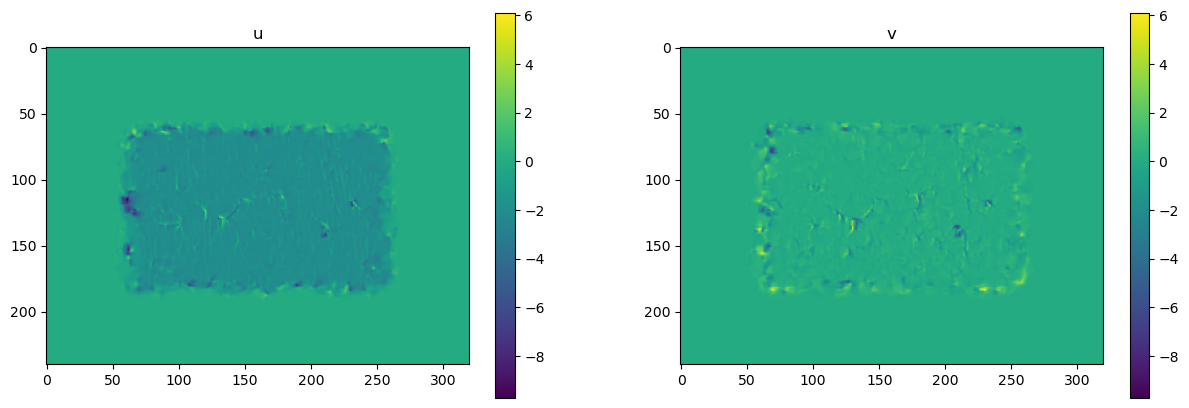

In [16]:
uv_iterative = iterative_KL(shift0_blurred, shiftR2_blurred, window_size=5, num_iters=10)
view_displacement(uv_iterative)

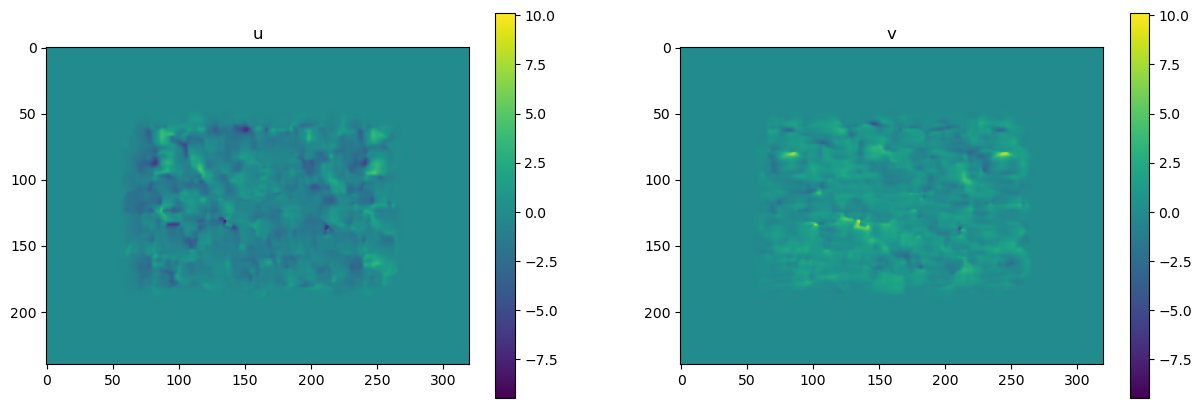

In [17]:
shiftR5U5_blurred = blur_image(shiftR5U5_gray, sigma=1)
uv = KL_step(shiftR2_blurred, shiftR5U5_blurred, window_size=10)
view_displacement(uv)

In [18]:
shiftR10 = plt.imread('D:\Projects\pythonProject\CV\course_resources\ps_5\TestSeq\ShiftR10.png')
shiftR20 = plt.imread('D:\Projects\pythonProject\CV\course_resources\ps_5\TestSeq\ShiftR20.png')
shiftR40 = plt.imread('D:\Projects\pythonProject\CV\course_resources\ps_5\TestSeq\ShiftR40.png')

shiftR10_blurred = blur_image(shiftR10[:, :, 0], sigma=1)
shiftR20_blurred = blur_image(shiftR20[:, :, 0], sigma=1)
shiftR40_blurred = blur_image(shiftR40[:, :, 0], sigma=1)


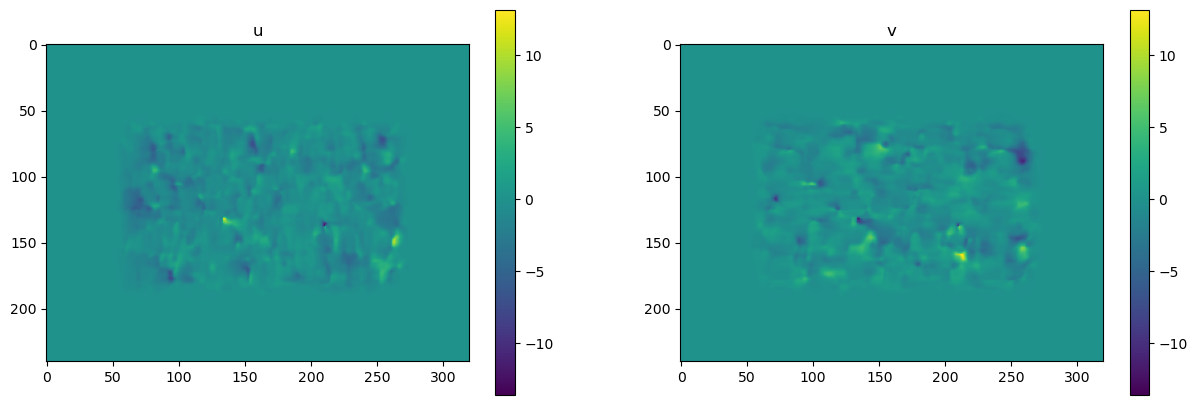

In [19]:
uv = KL_step(shift0_blurred, shiftR10_blurred, window_size=10)
view_displacement(uv)

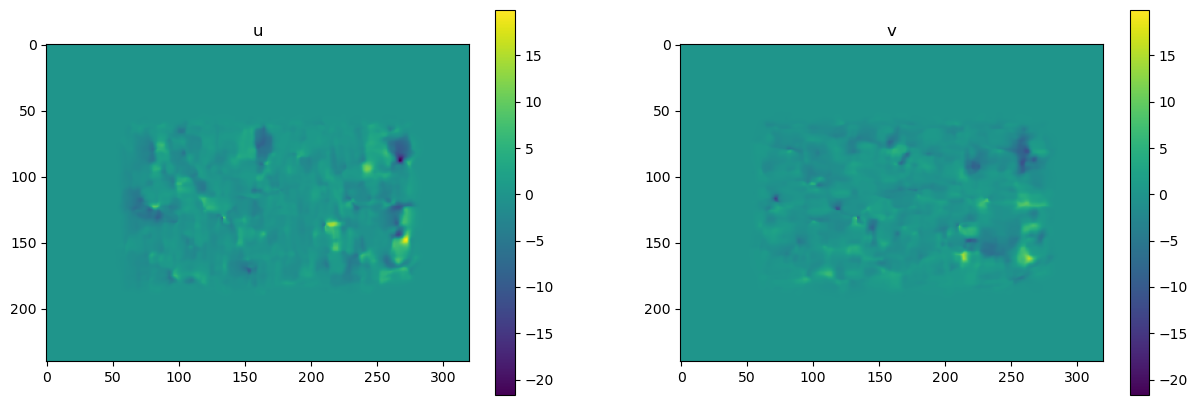

In [20]:
uv = KL_step(shift0_blurred, shiftR20_blurred, window_size=10)
view_displacement(uv)

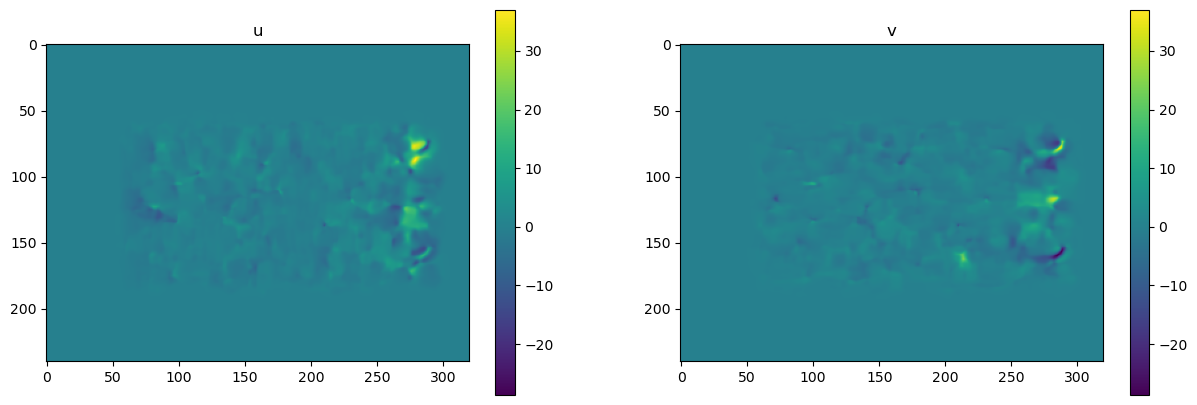

In [21]:
uv = KL_step(shift0_blurred, shiftR40_blurred, window_size=10)
view_displacement(uv)

In [22]:
# Implementing Gaussian Pyramid:

def reduce(img, levels=1):
    """Reduce the image size by half for 'levels' number of times."""
    reduce_filter = np.array([[1, 4, 6, 4, 1]]) / 16
    images = [img]

    for _ in range(levels):
        img = cv2.filter2D(img, -1, reduce_filter)
        img = cv2.filter2D(img, -1, reduce_filter.T)
        img = img[::2, ::2]
        images.append(img)

    return images

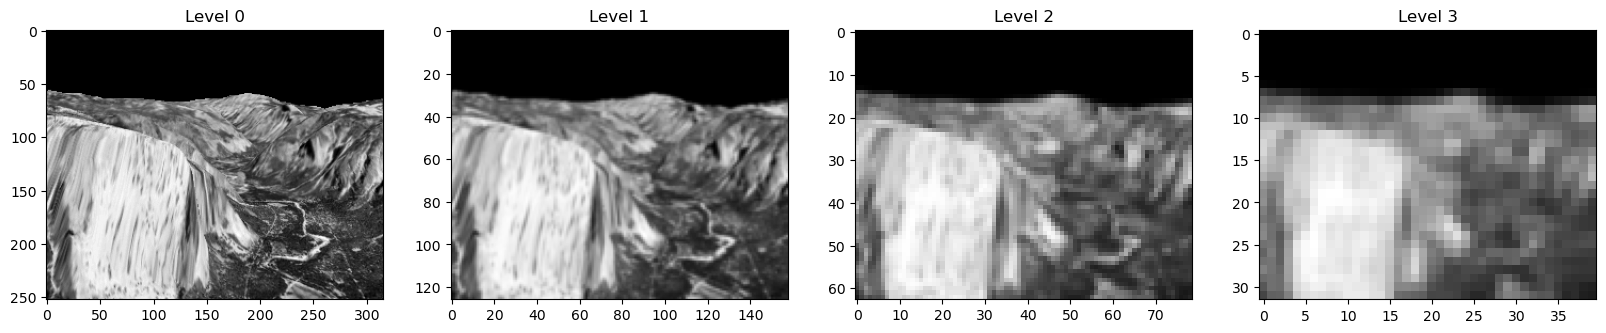

In [23]:
# Test the reduce function
image = plt.imread("D:\Projects\pythonProject\CV\course_resources\ps_5\DataSeq1\yos_img_01.jpg")

pyramid = reduce(image, levels=3)

plt.figure(figsize=(20, 5))
for i, img in enumerate(pyramid):
    plt.subplot(1, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Level {i}")
plt.show()

In [24]:
def expand(img, levels=1):
    """Expand the image size by double for 'levels' number of times."""
    expand_filter = np.array([[1, 4, 6, 4, 1]]) / 8
    images = [img]

    for _ in range(levels):
        h, w = img.shape
        img_expanded = np.zeros((h * 2, w * 2))
        img_expanded[::2, ::2] = img
        img_expanded = cv2.filter2D(img_expanded, -1, expand_filter)
        img_expanded = cv2.filter2D(img_expanded, -1, expand_filter.T)
        images.append(img_expanded)
        img = img_expanded

    return images

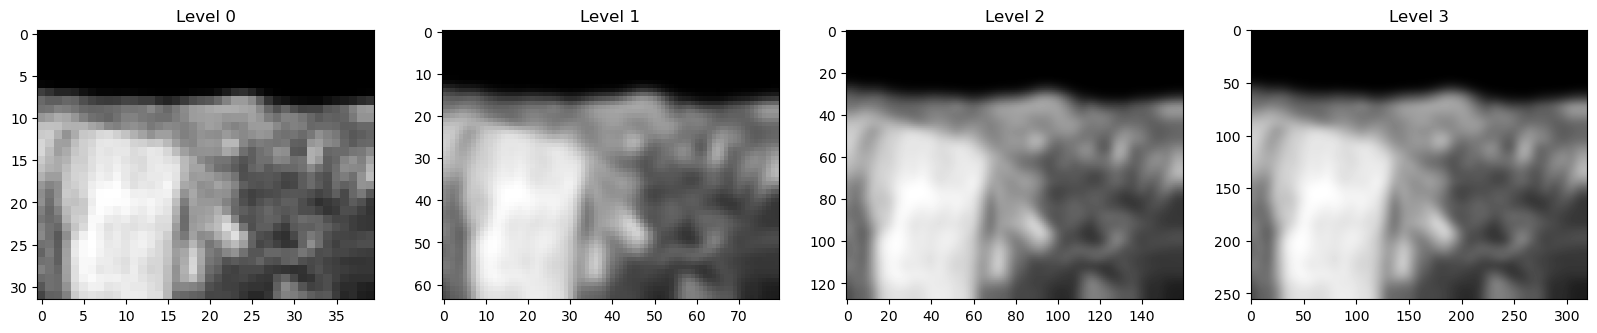

In [25]:
# Test the expand function
pyramid = expand(pyramid[3], levels=3)

plt.figure(figsize=(20, 5))
for i, img in enumerate(pyramid):
    plt.subplot(1, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Level {i}")
plt.show()

In [26]:
def crop_to_match(expanded, reference):
    """Crop the expanded image to match the reference image size."""
    h_exp, w_exp = expanded.shape
    h_ref, w_ref = reference.shape

    # Determine the crop dimensions based on reference size
    crop_h = h_exp - h_ref
    crop_w = w_exp - w_ref

    cropped = expanded[:h_exp - crop_h, :w_exp - crop_w]  # Crop to match original shape

    return cropped

In [27]:
def laplacian_pyramid(img, levels=3):
    """Construct the Laplacian pyramid of an image."""
    pyramid = []

    # Construct the Gaussian pyramid
    gaussian_pyramid = reduce(img, levels)

    for i in range(levels):
        expanded = expand(gaussian_pyramid[i + 1])[-1]
        cropped = crop_to_match(expanded, gaussian_pyramid[i])
        laplacian = gaussian_pyramid[i] - cropped
        pyramid.append(laplacian)

    pyramid.append(gaussian_pyramid[-1])  # Add the last level of the Gaussian pyramid
    return pyramid

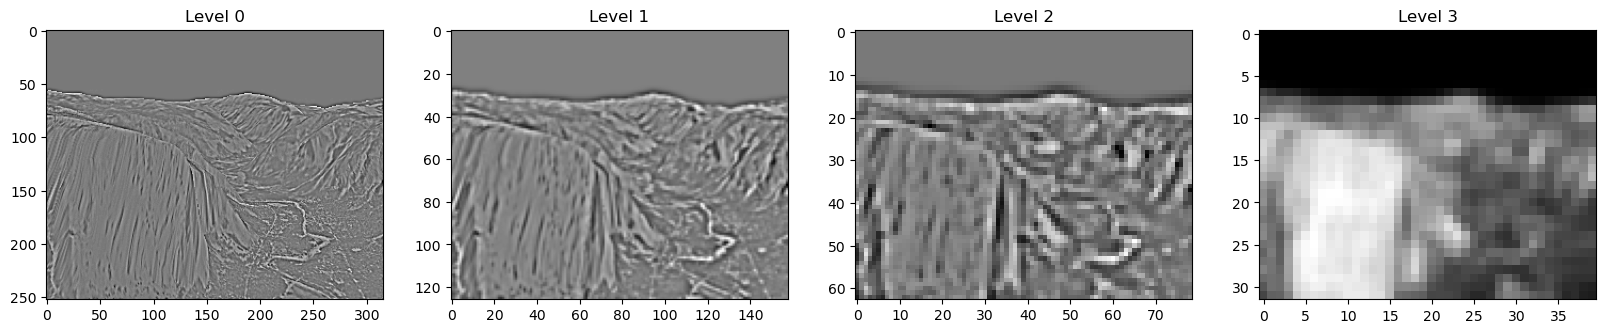

In [28]:
# Test the Laplacian pyramid function'
pyramid = laplacian_pyramid(image, levels=3)

plt.figure(figsize=(20, 5))
for i, img in enumerate(pyramid):
    plt.subplot(1, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Level {i}")
plt.show()

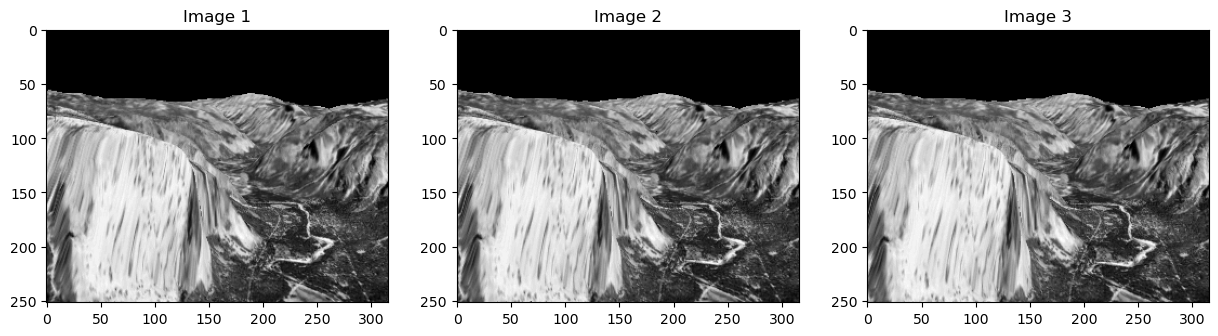

In [29]:
img1 = plt.imread("D:\Projects\pythonProject\CV\course_resources\ps_5\DataSeq1\yos_img_01.jpg")
img2 = plt.imread("D:\Projects\pythonProject\CV\course_resources\ps_5\DataSeq1\yos_img_02.jpg")
img3 = plt.imread("D:\Projects\pythonProject\CV\course_resources\ps_5\DataSeq1\yos_img_03.jpg")

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title("Image 1")
plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.title("Image 2")
plt.subplot(1, 3, 3)
plt.imshow(img3, cmap='gray')
plt.title("Image 3")
plt.show()

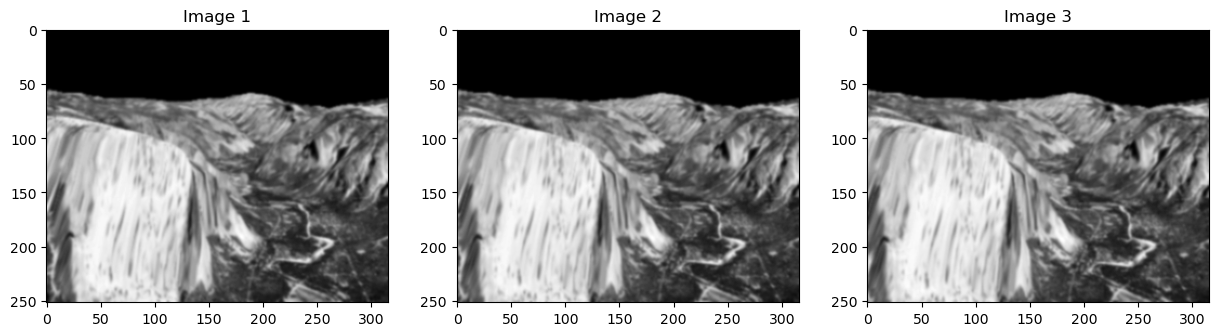

In [30]:
img1 = blur_image(img1, sigma=1)
img2 = blur_image(img2, sigma=1)
img3 = blur_image(img3, sigma=1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title("Image 1")
plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.title("Image 2")
plt.subplot(1, 3, 3)
plt.imshow(img3, cmap='gray')
plt.title("Image 3")
plt.show()

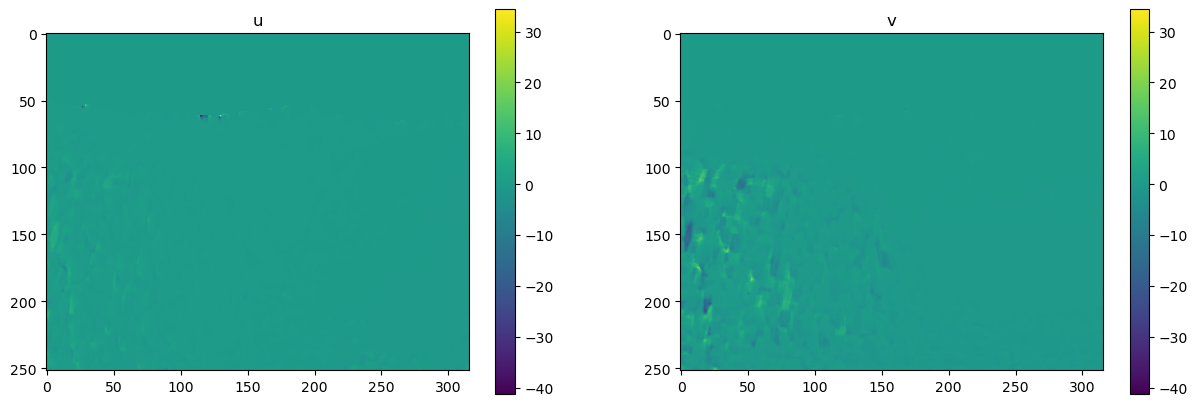

In [31]:
uv = KL_step(img1, img2, window_size=5)
view_displacement(uv)

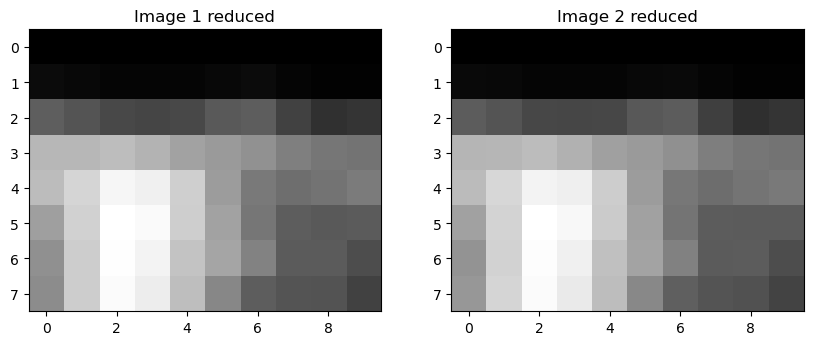

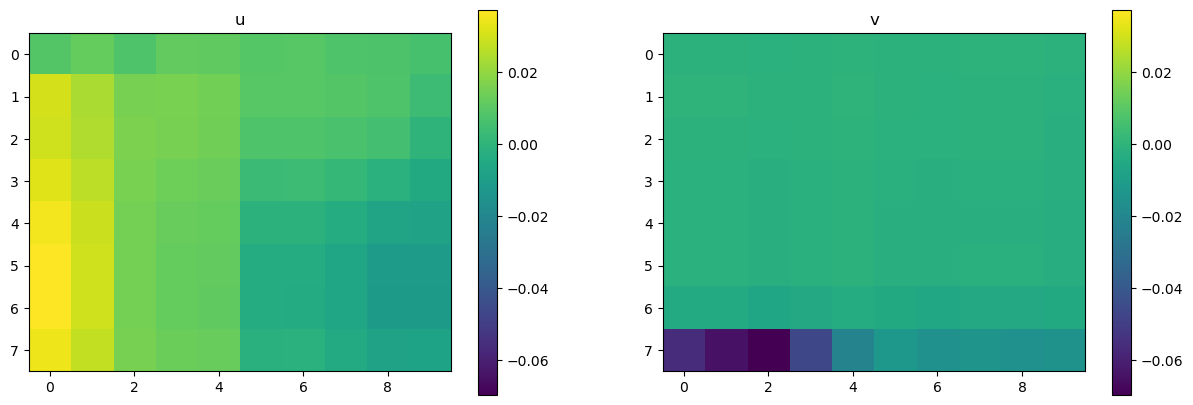

In [51]:
img1_reduced = reduce(img1, levels=5)[-1]
img2_reduced = reduce(img2, levels=5)[-1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1_reduced, cmap='gray')
plt.title("Image 1 reduced")
plt.subplot(1, 2, 2)
plt.imshow(img2_reduced, cmap='gray')
plt.title("Image 2 reduced")

uv = KL_step(img1_reduced, img2_reduced, window_size=7)
view_displacement(uv)

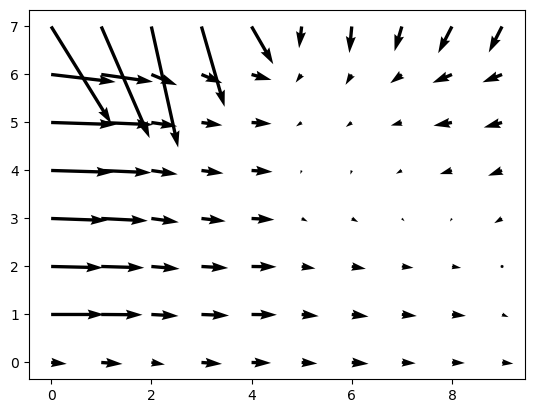

In [52]:
view_arrows(uv, scale=1)

In [34]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time


def flicker_images(img1, img2, flicker_count=10, flicker_interval=0.5):
    """
    Create a flicker effect by alternating between two images (for Jupyter Notebooks).

    Args:
    - img1: First image (numpy array).
    - img2: Second image (numpy array).
    - flicker_count: Number of times to flicker between the two images.
    - flicker_interval: Time in seconds between each flicker.
    """
    for _ in range(flicker_count):
        # Display the first image
        plt.imshow(img1, cmap='gray')
        plt.axis('off')  # Hide axis
        display(plt.gcf())  # Display the current figure
        time.sleep(flicker_interval)  # Pause
        clear_output(wait=True)  # Clear the output for flicker effect

        # Display the second image
        plt.imshow(img2, cmap='gray')
        plt.axis('off')  # Hide axis
        display(plt.gcf())  # Display the current figure
        time.sleep(flicker_interval)  # Pause
        clear_output(wait=True)  # Clear the output for flicker effect


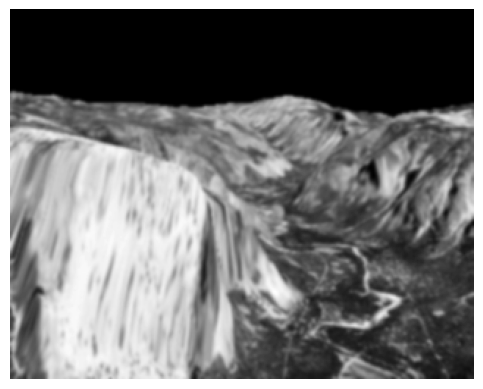

In [53]:
flicker_images(img1, img2, flicker_count=4, flicker_interval=0.5)

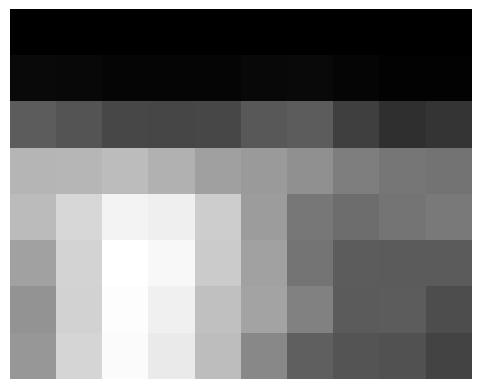

In [54]:
flicker_images(img1_reduced, img2_reduced, flicker_count=4, flicker_interval=0.5)

In [37]:
def wrap_image(img, uv):
    """Wrap img according to flow uv using bilinear interpolation."""
    h, w = img.shape

    # Create a grid of coordinates
    x, y = np.meshgrid(np.arange(w), np.arange(h))

    # Apply displacement (u, v)
    x_new = (x + uv[..., 0]).astype(np.float32)
    y_new = (y + uv[..., 1]).astype(np.float32)

    # Use OpenCV remap for bilinear interpolation to wrap the image
    img_wrapped = cv2.remap(img, x_new, y_new, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                            borderValue=0)

    return img_wrapped

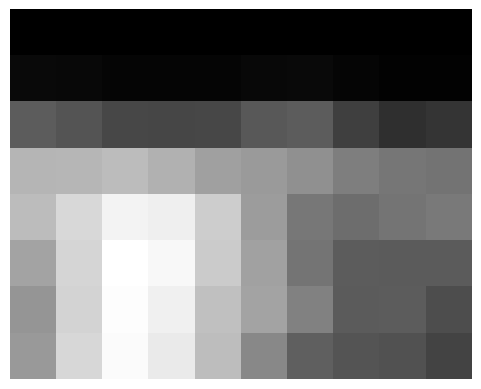

In [55]:
img2_wrapped = wrap_image(img2_reduced, uv)

flicker_images(img1_reduced, img2_wrapped, flicker_count=4)

In [71]:
def hierarchical_LK(img1, img2, levels=4, window_size=5):
    img1_gaussian = reduce(img1, levels=levels)
    img2_gaussian = reduce(img2, levels=levels)

    uv = 0
    for i in range(1, levels + 2):
        uv_p = np.zeros_like(np.stack((img1_gaussian[-i], img1_gaussian[-i]), axis=-1))
        uv_p[::2, ::2] = uv * 2
        try:
            uv_p[1::2, 1::2] = uv * 2
        except:
            uv_p[1::2, 1::2] = uv[:uv.shape[0] - 1, :uv.shape[1] - 1] * 2
        img2_wrapped = wrap_image(img2_gaussian[-i], uv_p)
        uv = KL_step(img1_gaussian[-i], img2_wrapped, window_size=window_size)
        window_size *= 2
        window_size += 1

    return uv

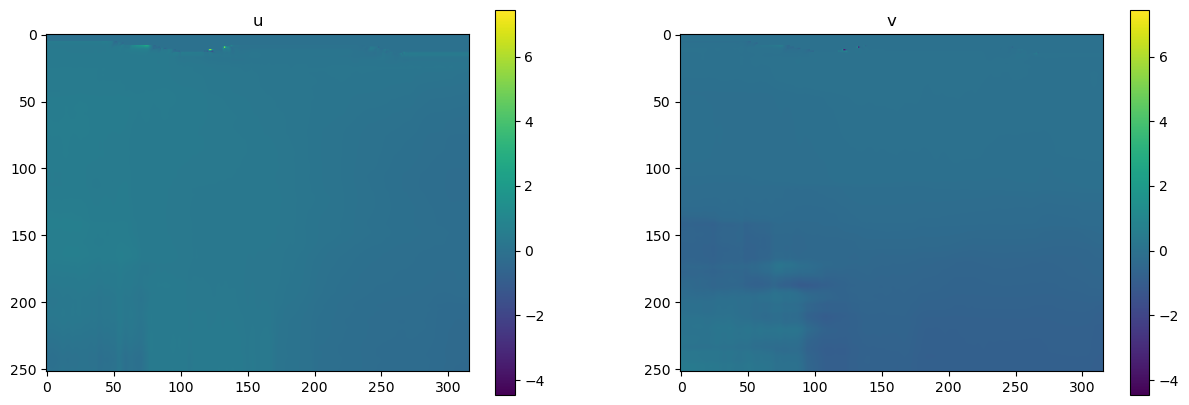

In [72]:
uv = hierarchical_LK(img1, img2, levels=4)
view_displacement(uv)

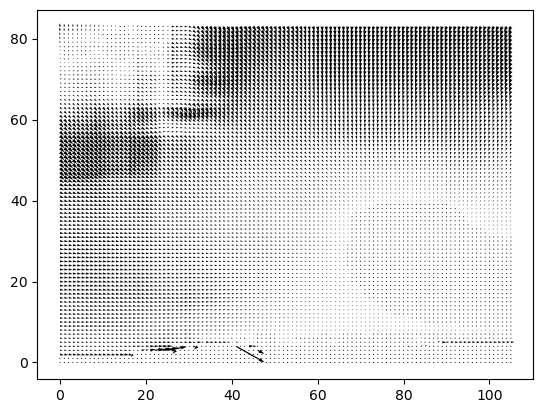

In [73]:
view_arrows(uv)

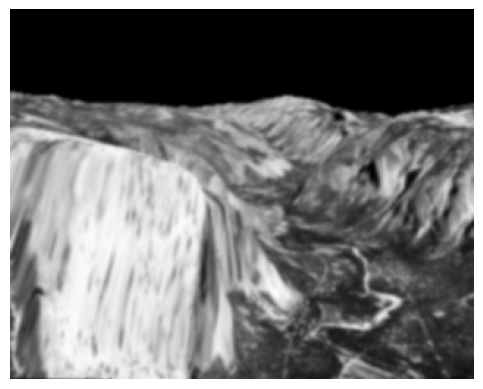

In [74]:
img2_wrapped = wrap_image(img2, uv)

flicker_images(img1, img2_wrapped, flicker_count=4)

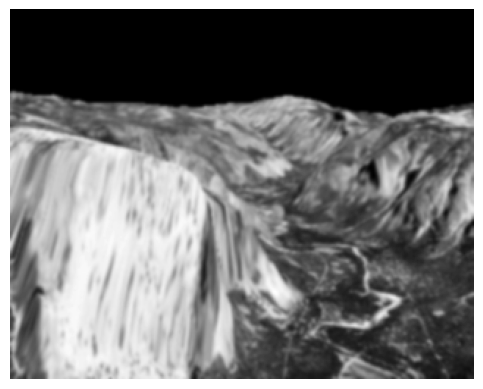

In [69]:
flicker_images(img1, img2, flicker_count=4)

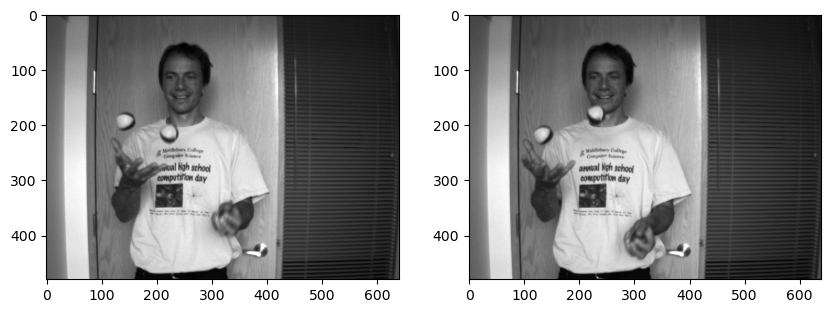

In [77]:
img1_juggle = plt.imread("D:\Projects\pythonProject\CV\course_resources\ps_5\Juggle\\0.png")
img2_juggle = plt.imread("D:\Projects\pythonProject\CV\course_resources\ps_5\Juggle\\1.png")

imgj1 = cv2.cvtColor(img1_juggle, cv2.COLOR_BGR2GRAY)
imgj2 = cv2.cvtColor(img2_juggle, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(imgj1, cmap='gray')
plt.subplot(122)
plt.imshow(imgj2, cmap='gray')
plt.show()

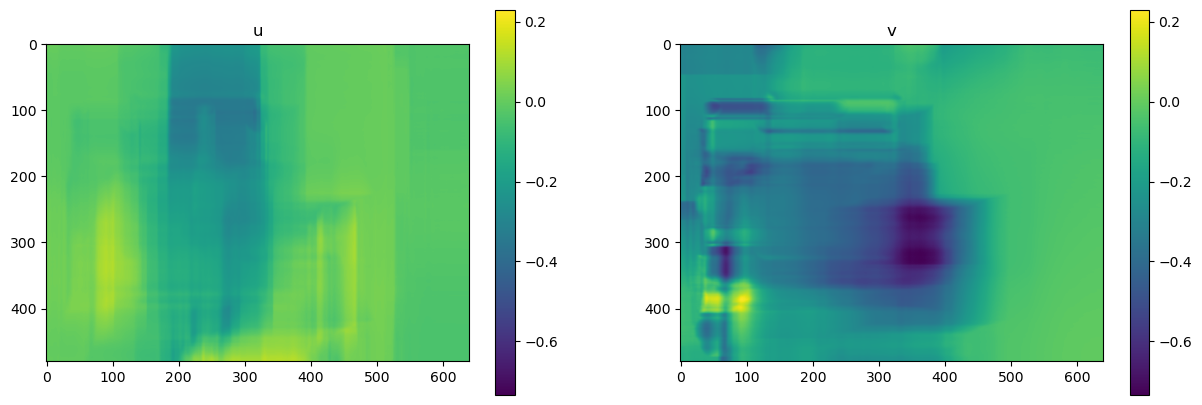

In [93]:
uv = hierarchical_LK(imgj1, imgj2, levels=5, window_size=5)
view_displacement(uv)

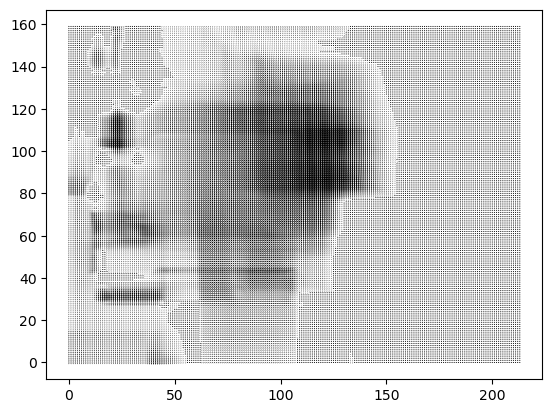

In [94]:
view_arrows(uv*2)

In [95]:
flicker_images(imgj1, imgj2, flicker_count=4)

In [106]:
imgj2_wrapped = wrap_image(imgj2, uv*64)
plt.imshow(imgj2_wrapped)
plt.show()

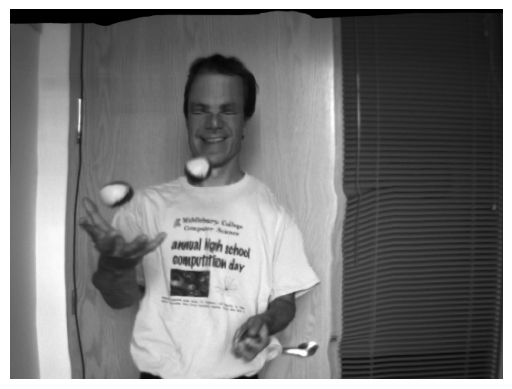

In [108]:
flicker_images(imgj1, imgj2_wrapped, flicker_count=4)